<a href="https://colab.research.google.com/github/MatiasMingo/ML-Colab-Projects/blob/main/Personal%20Projects/DQL_ResourceManagement.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
!pip install tensorflow
!pip install gym
!pip install keras
!pip install keras-rl2

In [17]:
import tensorflow as tf
from gym import Env
from gym.spaces import Discrete, Box
import numpy as np
import random

**Environment and Agent**

---



We are individual organisms (we manage ourselves towards the world)

We are one organism (we manage each other)

------> Agent is also an environment 

**IDEA: Society is not one environment, there should be multiple environments or layers to society, from smallest to biggest. The smallest environment should be the individual, then a community and then a cluster of communities.


**IDEA: First focus on supply and demand between companies or industries

*   Environment: group of companies. Industry based economy
*   Agent: company. 
*   Actions: supply, demand


Environment:

*   companies
*   supply-chain relationships
*   random ocurrences
*   random ocurrences


Agent:

*   demand of products and/or services at a point in time
*   supply of products and/or services at a point in time
*   capital (categorized by liquidity or nature) at a point in time
*   relation with other agents
*   supply of products and/or services at a point in time

Actions
*   demand of products and/or services at a point in time
*   supply of products and/or services at a point in time
*   CONSIDER delays in and time for executing 







# Hyperparameters

In [18]:
NUM_MACHINES = 3

## Environment

In [19]:
class Environment(Env):

  def __init__(self):
    # Actions we can take, produce, sell, stay
    self.action_space = Discrete(3)
    self.demand = random.randint(0,5)
    self.sold = 0
    self.produced = 0
    self.supply = 0
    self.observation_high = np.array([
      np.finfo(np.float32).max,
      np.finfo(np.float32).max,
      np.finfo(np.float32).max])
    self.observation_space = Box(low=np.array([0, 0, 0]), high= self.observation_high)
    # Random initial state - Amount of Money (100 +- 50 USD)
    self.state = np.array([self.demand, self.supply, 100 + random.randint(-50,50)])
    # Length of interaction - 288 intervals of 5 minutes in a day*****
    self.interaction_length = 288

  def excecute_action(self,action):
    #produce
    if action == 0:
      price_mango = 1 + random.uniform(-0.2,0.2)
      price_papaya = 1.4 + random.uniform(-0.3,0.4)
      price_water = 0.2 + random.uniform(-0.002,0.01)
      cost_smoothie = price_mango + price_papaya + price_water
      self.supply += NUM_MACHINES
      self.produced += NUM_MACHINES
      return np.array([self.demand, self.supply, float(self.state[2]) - (cost_smoothie)*NUM_MACHINES])
    #sell
    elif action == 1:
      if self.supply > 0 and self.demand > 0:
        self.supply -=  NUM_MACHINES
        self.demand -= NUM_MACHINES
        self.sold += NUM_MACHINES
        return np.array([self.demand, self.supply, self.state[2] + 7*NUM_MACHINES])
      else:
        return self.state
    #do nothing
    elif action == 2:
      return self.state
      
  def step(self, action):
    # Apply action - DEFINE (How much money was made) ******
    previous_state = self.state
    self.state = self.excecute_action(action) 
    #print("supply:{}, demand:{}".format(self.supply, self.demand)) 
    self.demand += random.randint(-1,5)
    if self.demand < 0:
      self.demand = 0
    # Reduce 5 minute intervals by one in interaction_length
    self.interaction_length -= 1 
    
    # Calculate reward
    if self.state[2] > previous_state[2]: 
      reward = 1 
    elif self.state[2] == previous_state[2]:
      reward = 0
    else: 
      reward = -1 
    
    # Check if interaction is done
    if self.interaction_length <= 0: 
        done = True
        #print("produced: {}, sold:{}".format(self.produced, self.sold))
    else:
        done = False
    
    # Apply noise
    #self.state += random.randint(-1,1)
    # Set placeholder for info
    info = {}
    
    # Return step information
    return self.state, reward, done, info
  
  def render(self):
      # Implement viz
      pass
  
  def reset(self):
      # Reset interaction time
      self.produced = 0
      self.sold = 0
      self.demand = 0
      self.supply = 0
      self.interaction_length = 288
      # Reset state
      self.state = np.array([self.demand, self.supply, 100 + random.randint(-50,50)])
      return self.state

In [20]:
env = Environment()
np.random.seed(123)
env.seed(123)

In [21]:
env.observation_space.sample()

array([1.0787905e+38, 2.8873529e+38, 3.3959250e+38], dtype=float32)

In [22]:
episodes = 10
for episode in range(1, episodes+1):
    state = env.reset()
    done = False
    score = 0 
    while not done:
        #env.render()
        """Picks uniformly random from all possible actions, using the environments
        action_space.sample() method."""
        action = env.action_space.sample()
        n_state, reward, done, info = env.step(action)
        print("state:{}, reward:{}, done:{}, info:{}".format(n_state, reward, done, info))
        score+=reward
    print('Episode:{} Score:{}'.format(episode, score))

state:[ 0  0 90], reward:0, done:False, info:{}
state:[ 2.          3.         81.06396214], reward:-1, done:False, info:{}
state:[ 7.          6.         72.62065929], reward:-1, done:False, info:{}
state:[11.          9.         64.41001121], reward:-1, done:False, info:{}
state:[11.          6.         85.41001121], reward:1, done:False, info:{}
state:[ 12.           3.         106.41001121], reward:1, done:False, info:{}
state:[ 12.           3.         106.41001121], reward:0, done:False, info:{}
state:[ 17.           0.         127.41001121], reward:1, done:False, info:{}
state:[ 17.           0.         127.41001121], reward:0, done:False, info:{}
state:[ 17.           0.         127.41001121], reward:0, done:False, info:{}
state:[ 21.           3.         119.88500914], reward:-1, done:False, info:{}
state:[ 20.           6.         111.07830215], reward:-1, done:False, info:{}
state:[ 18.           3.         132.07830215], reward:1, done:False, info:{}
state:[ 21.           6

# Create a Deep Learning Model with Keras

In [23]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam

In [24]:
states = env.observation_space.shape
print(states)
actions = env.action_space.n
print(actions)

(3,)
3


In [25]:
def build_model(states, actions):
    model = Sequential()   
    model.add(Flatten(input_shape=(1,) + env.observation_space.shape))
    model.add(Dense(9, activation='relu', input_shape=states))
    model.add(Dense(9, activation='relu'))
    model.add(Dense(actions, activation='linear'))
    return model

In [26]:
try:
  del model 
except:
  pass

In [27]:
model = build_model(states, actions)

In [28]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 3)                 0         
                                                                 
 dense_3 (Dense)             (None, 9)                 36        
                                                                 
 dense_4 (Dense)             (None, 9)                 90        
                                                                 
 dense_5 (Dense)             (None, 3)                 30        
                                                                 
Total params: 156
Trainable params: 156
Non-trainable params: 0
_________________________________________________________________


# Build Agent with Keras-RL

In [29]:
from rl.agents.dqn import DQNAgent
from rl.policy import LinearAnnealedPolicy, BoltzmannQPolicy, EpsGreedyQPolicy
from rl.memory import SequentialMemory
from rl.core import Processor
from rl.callbacks import FileLogger, ModelIntervalCheckpoint

In [30]:
def build_agent(model, actions):
    policy = BoltzmannQPolicy()
    memory = SequentialMemory(limit=50000, window_length=1)
    dqn = DQNAgent(model=model, memory=memory, policy=policy, 
                  nb_actions=actions, nb_steps_warmup=10, target_model_update=1e-2)
    return dqn

In [31]:
dqn = build_agent(model, actions)
dqn.compile(Adam(lr=1e-3), metrics=['mae'])
dqn.fit(env, nb_steps=50000, visualize=False, verbose=1)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Training for 50000 steps ...
Interval 1 (0 steps performed)


/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


    1/10000 [..............................] - ETA: 3:49:50 - reward: 0.0000e+00

/usr/local/lib/python3.7/dist-packages/rl/memory.py:37: UserWarning: Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!
  warnings.warn('Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!')


10000/10000 [==============================] - 126s 12ms/step - reward: -0.0101
34 episodes - episode_reward: -2.971 [-39.000, 0.000] - loss: 7.481 - mae: 14.575 - mean_q: 36.874

Interval 2 (10000 steps performed)
10000/10000 [==============================] - 123s 12ms/step - reward: -0.0027
35 episodes - episode_reward: -0.743 [-4.000, 0.000] - loss: 3.681 - mae: 17.537 - mean_q: 27.178

Interval 3 (20000 steps performed)
10000/10000 [==============================] - 124s 12ms/step - reward: -0.0129
35 episodes - episode_reward: -3.714 [-54.000, 0.000] - loss: 1.993 - mae: 13.930 - mean_q: 21.268

Interval 4 (30000 steps performed)
10000/10000 [==============================] - 133s 13ms/step - reward: -0.0045
34 episodes - episode_reward: -1.324 [-10.000, 0.000] - loss: 0.626 - mae: 9.872 - mean_q: 15.103

Interval 5 (40000 steps performed)
10000/10000 [==============================] - 128s 13ms/step - reward: -0.0038
done, took 633.570 seconds


In [33]:
scores = dqn.test(env, nb_episodes=100, visualize=False)
print(np.mean(scores.history['episode_reward']))

Testing for 100 episodes ...
Episode 1: reward: 0.000, steps: 288
Episode 2: reward: 0.000, steps: 288
Episode 3: reward: 0.000, steps: 288
Episode 4: reward: 0.000, steps: 288
Episode 5: reward: 0.000, steps: 288
Episode 6: reward: 0.000, steps: 288
Episode 7: reward: 0.000, steps: 288
Episode 8: reward: 0.000, steps: 288
Episode 9: reward: 0.000, steps: 288
Episode 10: reward: 0.000, steps: 288
Episode 11: reward: 0.000, steps: 288
Episode 12: reward: 0.000, steps: 288
Episode 13: reward: 0.000, steps: 288
Episode 14: reward: 0.000, steps: 288
Episode 15: reward: 0.000, steps: 288
Episode 16: reward: 0.000, steps: 288
Episode 17: reward: 0.000, steps: 288
Episode 18: reward: 0.000, steps: 288
Episode 19: reward: 0.000, steps: 288
Episode 20: reward: 0.000, steps: 288
Episode 21: reward: 0.000, steps: 288
Episode 22: reward: 0.000, steps: 288
Episode 23: reward: 0.000, steps: 288
Episode 24: reward: 0.000, steps: 288
Episode 25: reward: 0.000, steps: 288
Episode 26: reward: 0.000, ste

In [35]:
_ = dqn.test(env, nb_episodes=15, visualize=False)

Testing for 15 episodes ...
Episode 1: reward: 0.000, steps: 288
Episode 2: reward: 0.000, steps: 288
Episode 3: reward: 0.000, steps: 288
Episode 4: reward: 0.000, steps: 288
Episode 5: reward: 0.000, steps: 288
Episode 6: reward: 0.000, steps: 288
Episode 7: reward: 0.000, steps: 288
Episode 8: reward: 0.000, steps: 288
Episode 9: reward: 0.000, steps: 288
Episode 10: reward: 0.000, steps: 288
Episode 11: reward: 0.000, steps: 288
Episode 12: reward: 0.000, steps: 288
Episode 13: reward: 0.000, steps: 288
Episode 14: reward: 0.000, steps: 288
Episode 15: reward: 0.000, steps: 288


# Reloading Agent from Memory

In [ ]:
dqn.save_weights('dqn_weights.h5f', overwrite=True)

In [ ]:
del model
del dqn
del env

In [ ]:
env = gym.make('CartPole-v0')
actions = env.action_space.n
states = env.observation_space.shape[0]
model = build_model(states, actions)
dqn = build_agent(model, actions)
dqn.compile(Adam(lr=1e-3), metrics=['mae'])

In [ ]:
dqn.load_weights('dqn_weights.h5f')

In [ ]:
_ = dqn.test(env, nb_episodes=5, visualize=True)

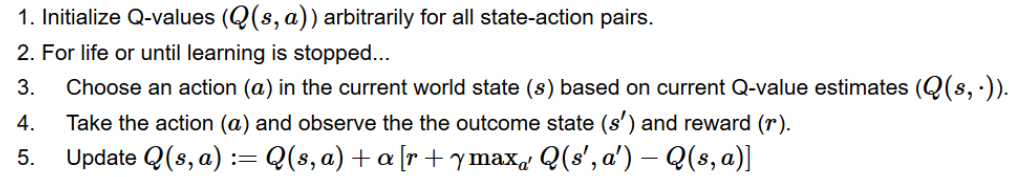